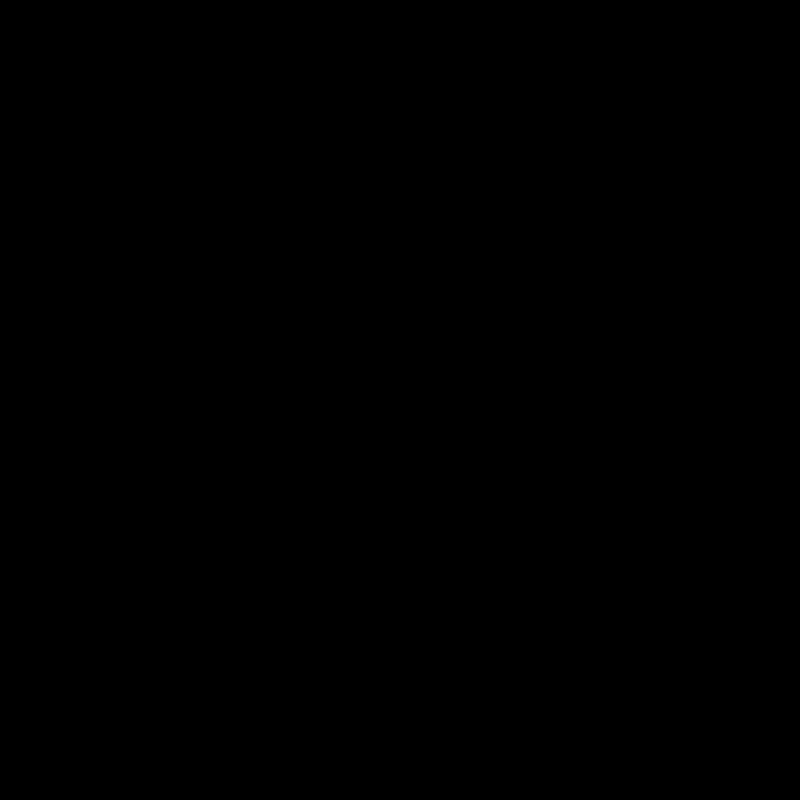

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

# Parameters
r = 10
res = 70

theta = np.linspace(0, 2*np.pi, res)
phi = np.linspace(0, np.pi, res)
theta_mesh, phi_mesh = np.meshgrid(theta, phi)

x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
z = r * np.cos(phi_mesh)

base_texture = np.ones((res, res, 4))
base_texture[:, :, 0:3] = [1.0, 0.65, 0]
base_texture[:, :, 3] = 1

spot_theta_deg = 0
spot_phi_deg   = 90
spot_radius_deg = 25

spot_theta_rad = np.deg2rad(spot_theta_deg)
spot_phi_rad   = np.deg2rad(spot_phi_deg)
spot_radius_rad = np.deg2rad(spot_radius_deg)

elev = 0
azim = 0

elev_rad = np.deg2rad(elev)
azim_rad = np.deg2rad(azim) 

v_x = np.cos(elev_rad) * np.cos(azim_rad)
v_y = np.cos(elev_rad) * np.sin(azim_rad)
v_z = np.sin(elev_rad)

plt.style.use('dark_background')
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((0.98,1,0.95))
ax.set_axis_off()
ax.view_init(elev=elev, azim=azim, vertical_axis="z") 

u = 0.8

mu = (x * v_x + y * v_y + z * v_z) / r
mu = np.clip(mu, 0, 1)

# Guardamos I(mu) aparte
I_mu = (1 - u * (1 - mu))

# Aplicar limb darkening a la textura base
for c in range(3):  
    base_texture[:,:, c] *= I_mu

fluxes = []

def animate(i):
    ax.clear()
    ax.set_axis_off()
    ax.set_title(f'', color='white')

    texture = np.copy(base_texture)
    
    # Rotar la mancha
    spot_theta_rad = np.deg2rad(spot_theta_deg) + (2*np.pi*i/120)

    delta_theta = np.abs(theta_mesh - spot_theta_rad)
    delta_theta = np.minimum(delta_theta, 2*np.pi - delta_theta)
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    
    distance_squared = (delta_theta**2 + delta_phi**2)
    sigma_squared = (spot_radius_rad / 2)**2
    spot_mask = np.exp(-distance_squared / (2 * sigma_squared))
    
    texture[:, :, 0:3] *= (1 - 0.9 * spot_mask[:, :, np.newaxis])
    
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=texture, shade=False)

    brightness = texture[:, :, 0]  # canal R con limb darkening + mancha
    visible = mu > 0  # solo puntos hacia el observador
    total_flux = np.sum(brightness[visible])
    fluxes.append(total_flux)


    



    return [surf]

ani = animation.FuncAnimation(fig, animate, frames=120, interval=50, blit=False)
plt.show()



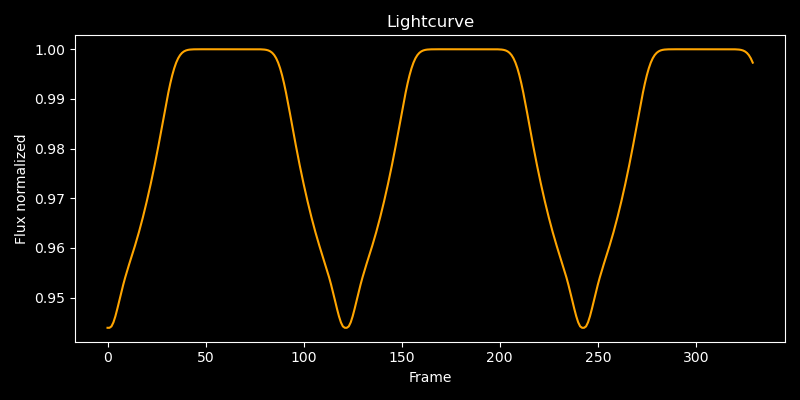

In [4]:
from sklearn.preprocessing import normalize
frames = np.arange(len(fluxes))
# Normalized
fluxes_normalized = normalize([fluxes], norm="max")[0]  


plt.figure(figsize=(8, 4))
plt.plot(frames, fluxes_normalized, color='orange')
plt.title('Lightcurve')
plt.xlabel('Frame')
plt.ylabel('Flux normalized')
plt.tight_layout()
plt.show()